In [22]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#Import libararies
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dropout

In [24]:
data_dir = '/content/drive/MyDrive/PROJEKT KONCOWY/data'
train = pd.read_csv(os.path.join(data_dir, 'train', '_classes.csv'))
val = pd.read_csv(os.path.join(data_dir, 'valid', '_classes.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test', '_classes.csv'))

In [45]:
#ImagedataGenerator
datagen = ImageDataGenerator(rescale=1./255)

#train
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=os.path.join(data_dir, 'train'),
    x_col='filename',
    y_col=train.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

# val
val_generator = datagen.flow_from_dataframe(
    dataframe=val,
    directory=os.path.join(data_dir, 'valid'),
    x_col='filename',
    y_col=train.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)

#test
test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    directory=os.path.join(data_dir, 'test'),
    x_col='filename',
    y_col=test.columns[1:],
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw'
)


Found 1716 validated image filenames.
Found 254 validated image filenames.
Found 203 validated image filenames.


In [26]:
def plot_history(history):
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)

In [27]:
def plot_random_predictions(model, data_generator, data_dir, num_images=3):
    for _ in range(num_images):
        random_index = np.random.randint(0, len(data_generator.filenames))
        random_image_path = os.path.join(data_dir, data_generator.directory,
                                         data_generator.filenames[random_index])

        img = image.load_img(random_image_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)

        predicted_class = np.argmax(prediction)
        class_labels = train.columns[1:]
        predicted_label = class_labels[predicted_class]

        plt.figure()
        plt.imshow(img)
        plt.title(f'Predicted Class: {predicted_label}')
        plt.axis('off')

In [28]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 100

#Model

model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))

model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

model1.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

model1.save('/content/drive/MyDrive/PROJEKT KONCOWY /own_model.h5')

test_loss_1, test_accuracy_1 = model1.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_1}')

Epoch 1/100
54/54 [==============================] - 9s 108ms/step - loss: 11.1488 - accuracy: 0.1661 - val_loss: 11.2813 - val_accuracy: 0.0394
Epoch 2/100
54/54 [==============================] - 4s 77ms/step - loss: 9.4633 - accuracy: 0.3840 - val_loss: 12.6916 - val_accuracy: 0.0630
Epoch 3/100
54/54 [==============================] - 5s 92ms/step - loss: 8.1505 - accuracy: 0.4977 - val_loss: 12.4591 - val_accuracy: 0.0394
Epoch 4/100
54/54 [==============================] - 5s 99ms/step - loss: 7.0695 - accuracy: 0.5740 - val_loss: 12.4527 - val_accuracy: 0.0394
Epoch 5/100
54/54 [==============================] - 5s 91ms/step - loss: 6.0291 - accuracy: 0.6684 - val_loss: 10.7011 - val_accuracy: 0.1339
Epoch 6/100
54/54 [==============================] - 4s 82ms/step - loss: 5.2263 - accuracy: 0.7069 - val_loss: 9.8196 - val_accuracy: 0.0827
Epoch 7/100
54/54 [==============================] - 6s 103ms/step - loss: 4.4660 - accuracy: 0.7611 - val_loss: 9.7608 - val_accuracy: 0.074

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 59ms/step - loss: 1.6443 - accuracy: 0.8227
Test Accuracy: 0.8226600885391235


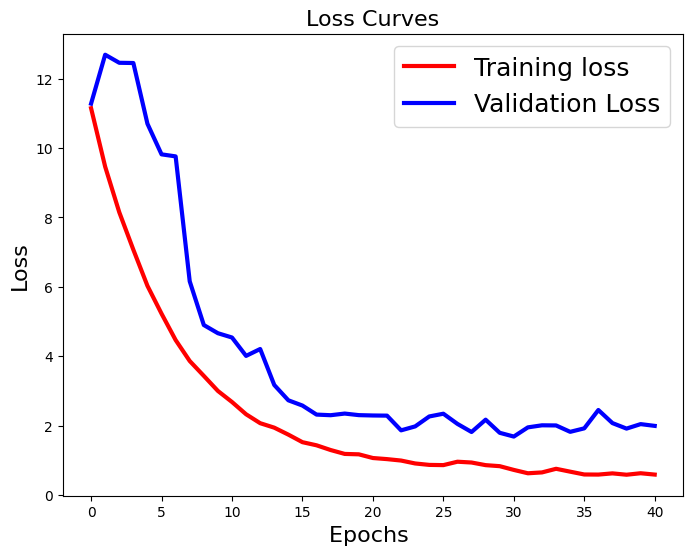

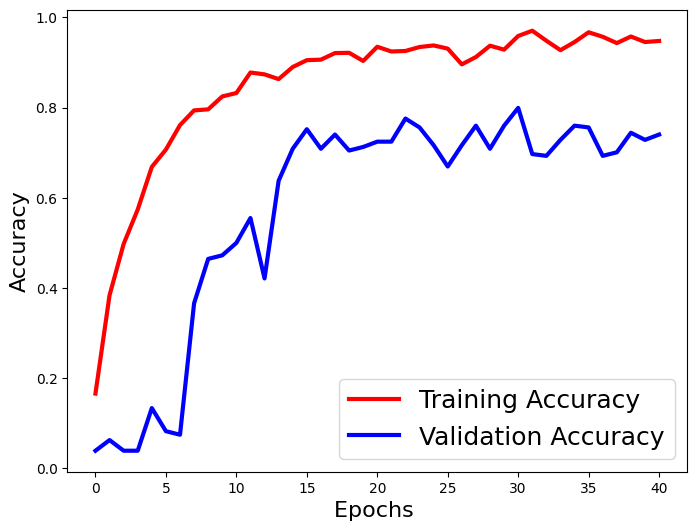

In [31]:
plot_history(history1)

1/1 [==============================] - 0s 21ms/step


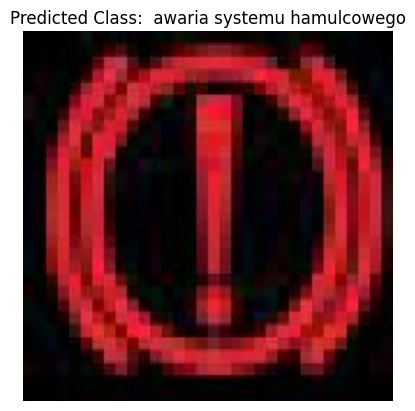

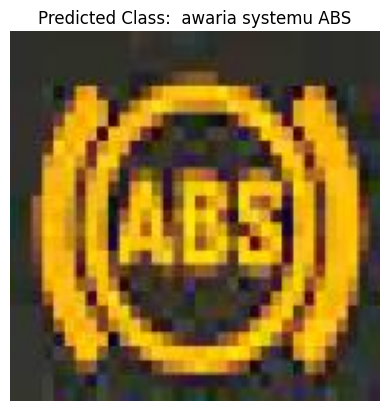

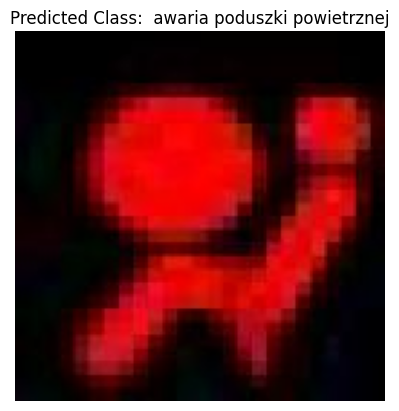

In [46]:
plot_random_predictions(model1, test_generator, data_dir)

In [33]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 100

#Model

base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

base_model.trainable = True

model2 = models.Sequential()
model2.add(base_model),
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

history2 = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=(val_generator),
    callbacks=[early_stopping]
)

model2.save("/content/drive/MyDrive/PROJEKT KONCOWY /DenseNet_model.h5")

test_loss_2, test_accuracy_2 = model2.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_2}')

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
54/54 [==============================] - 79s 299ms/step - loss: 3.4658 - accuracy: 0.0606 - val_loss: 3.1583 - val_accuracy: 0.0906
Epoch 2/100
54/54 [==============================] - 9s 158ms/step - loss: 3.2642 - accuracy: 0.0798 - val_loss: 3.0890 - val_accuracy: 0.1102
Epoch 3/100
54/54 [==============================] - 10s 179ms/step - loss: 3.1037 - accuracy: 0.1131 - val_loss: 2.9959 - val_accuracy: 0.1457
Epoch 4/100
54/54 [==============================] - 10s 175ms/step - loss: 2.9767 - accuracy: 0.1212 - val_loss: 2.9002 - val_accuracy: 0.2008
Epoch 5/100
54/54 [==============================] - 9s 158ms/step - loss: 2.8562 - accuracy: 0.1696 - val_loss: 2.8024 - val_accuracy: 0.2244
Epoch 6/100
54/54 [==============================] - 10s 186ms/step - loss: 2.7628 - accuracy: 0.1882 - val_loss: 2.7118 - val_accuracy: 0.2677
Epoch 7/100
54/54 [==============================] - 9s 169ms/step - loss

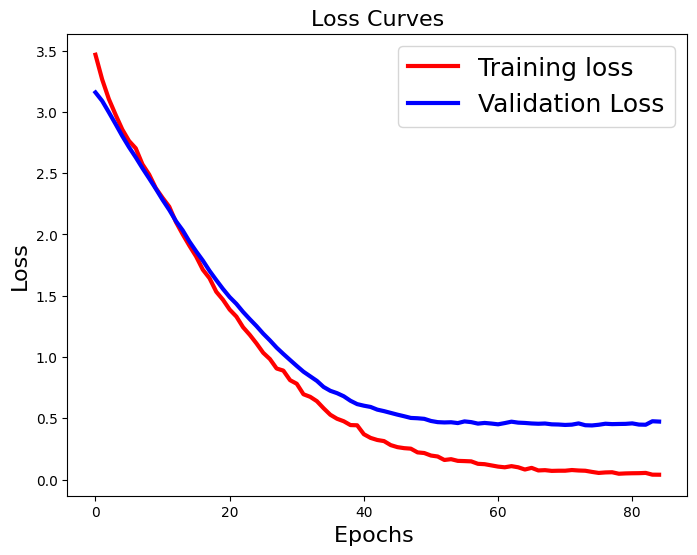

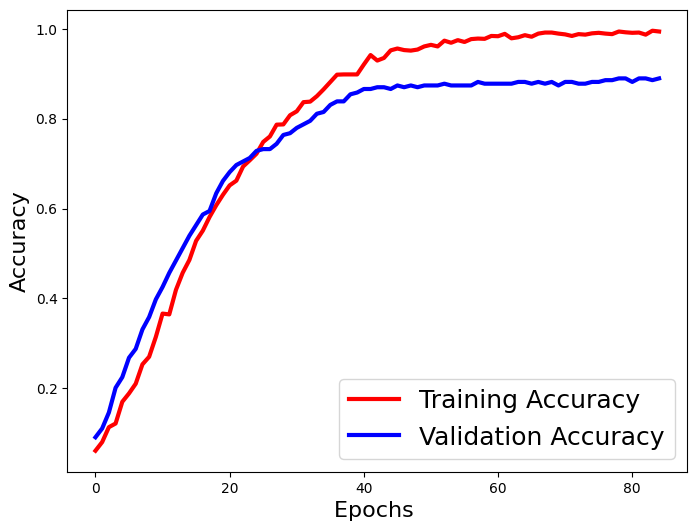

In [37]:
plot_history(history2)

1/1 [==============================] - 0s 29ms/step


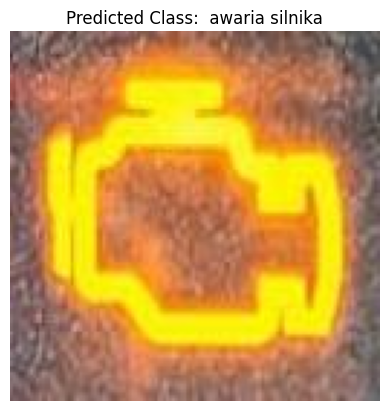

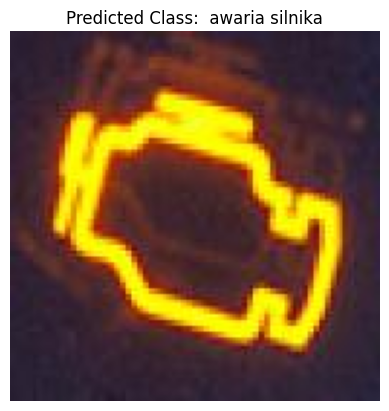

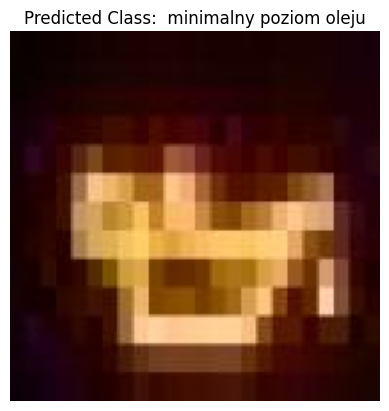

In [47]:
plot_random_predictions(model2, test_generator, data_dir)

In [36]:
#Parameters
input_shape = (128, 128, 3)
num_classes = 24
epochs = 100

#Model
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')

base_model.trainable = True

model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(24, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)

model3.compile(optimizer=Adam(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

model3.save("/content/drive/MyDrive/PROJEKT KONCOWY /MobileNetV2_model.h5")

test_loss_3, test_accuracy_3 = model3.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy_3}')

9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/100
54/54 [==============================] - 32s 128ms/step - loss: 3.0086 - accuracy: 0.1469 - val_loss: 4.0190 - val_accuracy: 0.0906
Epoch 2/100
54/54 [==============================] - 5s 89ms/step - loss: 1.8694 - accuracy: 0.4726 - val_loss: 9.4047 - val_accuracy: 0.1378
Epoch 3/100
54/54 [==============================] - 6s 113ms/step - loss: 1.3097 - accuracy: 0.6451 - val_loss: 7.9703 - val_accuracy: 0.1850
Epoch 4/100
54/54 [==============================] - 5s 88ms/step - loss: 0.8963 - accuracy: 0.7576 - val_loss: 14.6356 - val_accuracy: 0.1220
Epoch 5/100
54/54 [==============================] - 5s 83ms/step - loss: 0.7947 - accuracy: 0.7850 - val_loss: 15.0893 - val_accuracy: 0.1496
Epoch 6/100
54/54 [==============================] - 6s 119ms/step - loss: 0.7143 - accuracy: 0.8083 - val_loss: 6.4360 - val_accuracy: 0.1614
Epoch 7/100
54/54 [==============================] - 7s 127ms/step - loss: 0.5400 - accuracy: 0.8666 - val_loss: 9.2880 - val_accuracy: 0.1811

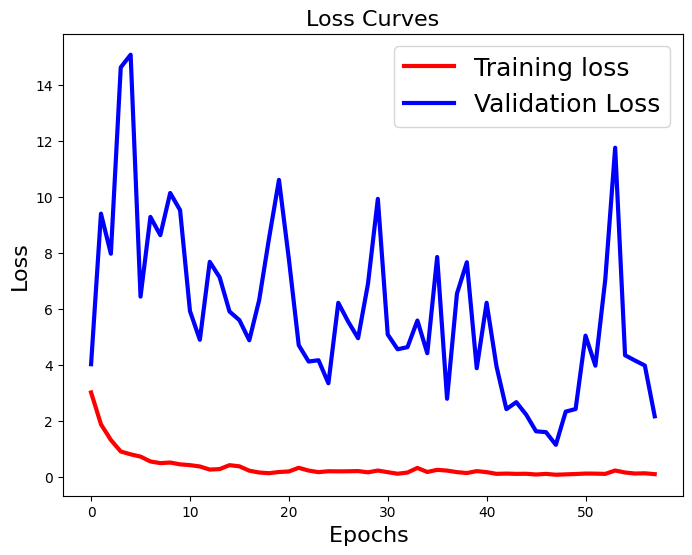

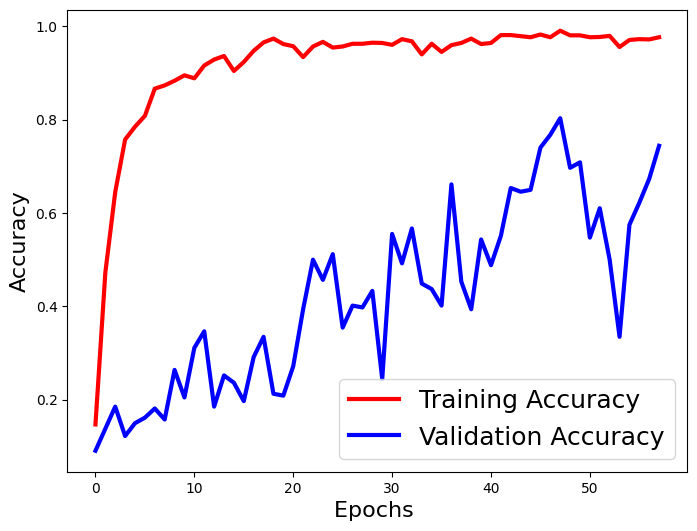

In [39]:
plot_history(history3)

1/1 [==============================] - 0s 21ms/step


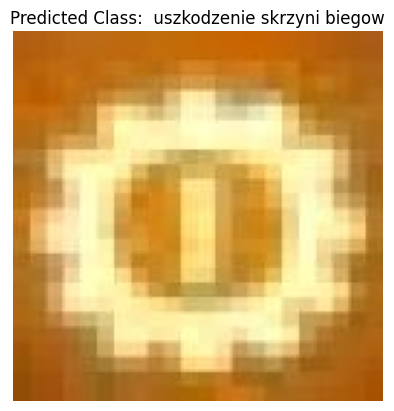

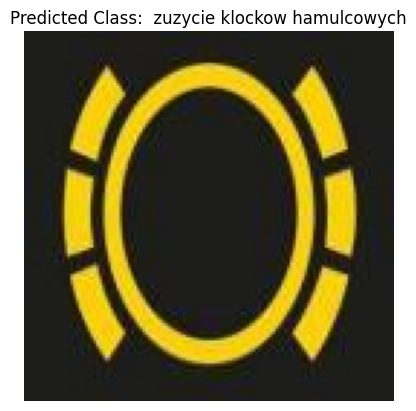

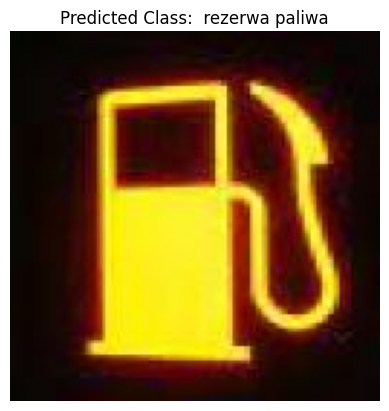

In [40]:
plot_random_predictions(model3, test_generator, data_dir)

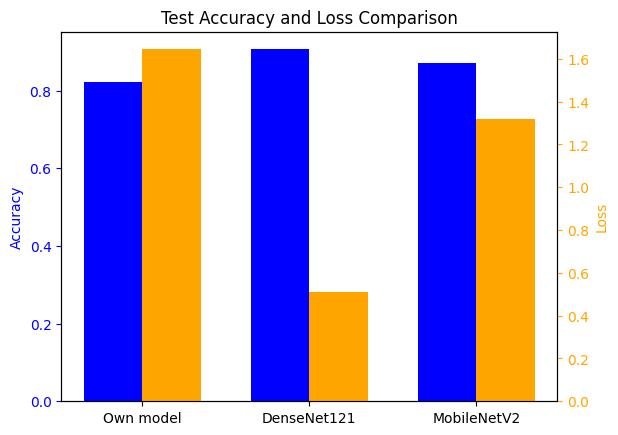

In [44]:
models = ['Own model', 'DenseNet121', 'MobileNetV2']
test_accuracies = [test_accuracy_1, test_accuracy_2, test_accuracy_3]
test_losses = [test_loss_1, test_loss_2, test_loss_3]

bar_width = 0.35
index = np.arange(len(models))

fig, ax1 = plt.subplots()

ax1.bar(index, test_accuracies, bar_width, label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.bar(index + bar_width, test_losses, bar_width, label='Loss', color='orange')
ax2.set_ylabel('Loss', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('Test Accuracy and Loss Comparison')
plt.xticks(index + bar_width / 2, models)
plt.show()
